In [3]:
import os
import zipfile
import shutil
import random

# ==== STEP 1: Unzip Uploaded Dataset ====
zip_path = "/home/varshith/Downloads/archive.zip"
extract_path = "/home/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset unzipped!")
print("Top-level folders:", os.listdir(extract_path))

PermissionError: [Errno 13] Permission denied: '/home/dataset'

In [2]:

# ==== STEP 2: Flatten into a single dataset folder with labels ====
# Merge Engaged and Not engaged folders
flat_dataset_path = "/content/flat_dataset"
os.makedirs(flat_dataset_path, exist_ok=True)

categories = {
    "Engaged": ["confused", "engaged", "frustrated"],
    "Not engaged": ["Looking Away", "bored", "drowsy"]
}

for parent_class, subfolders in categories.items():
    for sub in subfolders:
        src_folder = os.path.join(extract_path, parent_class, sub)
        dst_folder = os.path.join(flat_dataset_path, sub)
        os.makedirs(dst_folder, exist_ok=True)

        for file in os.listdir(src_folder):
            shutil.copy(os.path.join(src_folder, file), dst_folder)

print("✅ Flattened dataset created at:", flat_dataset_path)


✅ Flattened dataset created at: /content/flat_dataset


In [3]:

# ==== STEP 3: Split into train/test folders ====
def create_train_test_dirs(data_dir, train_dir, test_dir, test_ratio=0.2):
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for subclass in os.listdir(data_dir):
        subclass_path = os.path.join(data_dir, subclass)
        if not os.path.isdir(subclass_path):
            continue

        images = [f for f in os.listdir(subclass_path) if os.path.isfile(os.path.join(subclass_path, f))]
        random.shuffle(images)

        split_idx = int(len(images) * test_ratio)
        test_images = images[:split_idx]
        train_images = images[split_idx:]

        train_subclass_path = os.path.join(train_dir, subclass)
        test_subclass_path = os.path.join(test_dir, subclass)
        os.makedirs(train_subclass_path, exist_ok=True)
        os.makedirs(test_subclass_path, exist_ok=True)

        for image in train_images:
            shutil.copy(os.path.join(subclass_path, image), os.path.join(train_subclass_path, image))
        for image in test_images:
            shutil.copy(os.path.join(subclass_path, image), os.path.join(test_subclass_path, image))

# Paths
train_dir = "/content/train"
test_dir = "/content/test"

create_train_test_dirs(flat_dataset_path, train_dir, test_dir)

print("✅ Train/Test split done.")
print("Train classes:", os.listdir(train_dir))
print("Test classes:", os.listdir(test_dir))

✅ Train/Test split done.
Train classes: ['drowsy', 'bored', 'engaged', 'frustrated', 'Looking Away', 'confused']
Test classes: ['drowsy', 'bored', 'engaged', 'frustrated', 'Looking Away', 'confused']


In [4]:
import tensorflow as tf

# Load train and test datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),  # Resize images to a uniform size
    batch_size=32,
    label_mode='int',  # You can also use 'categorical' if you prefer one-hot encoding
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=32,
    label_mode='int',
    shuffle=False  # No shuffling for test set
)

# Verify the dataset loading
print("Train Dataset:", train_ds)
print("Test Dataset:", test_ds)


Found 1699 files belonging to 6 classes.
Found 421 files belonging to 6 classes.
Train Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


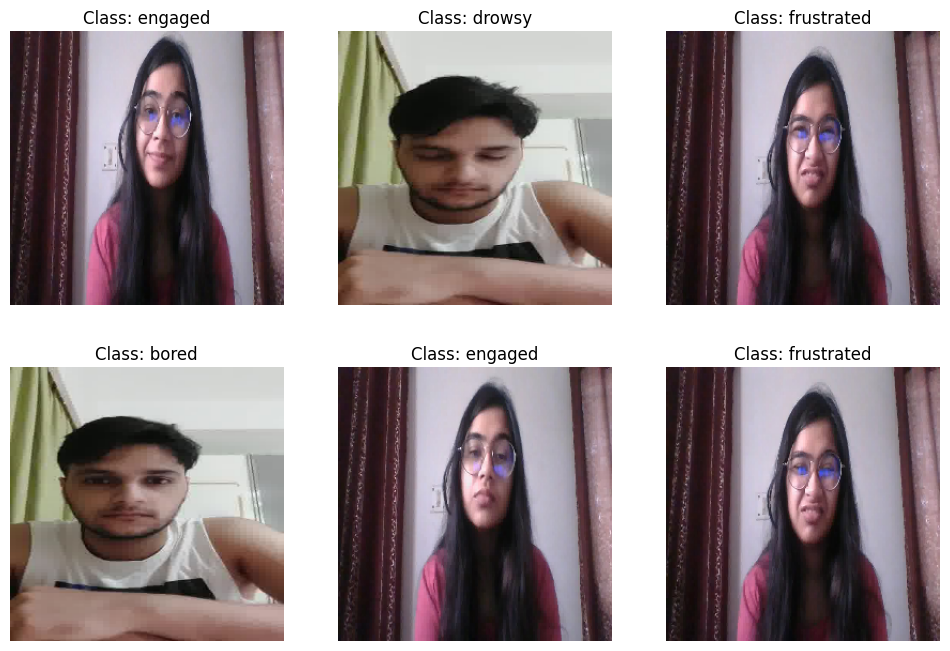

In [5]:
import matplotlib.pyplot as plt

# Visualize first 6 images from the training set
plt.figure(figsize=(12, 8))
for i, (image, label) in enumerate(train_ds.take(1)):
    for j in range(6):
        plt.subplot(2, 3, j+1)
        plt.imshow(image[j].numpy().astype("uint8"))
        plt.title(f"Class: {train_ds.class_names[label[j]]}")
        plt.axis("off")
plt.show()


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


In [7]:
train_dir = '/content/train'
test_dir = '/content/test'


In [8]:
# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For the test set, just rescale
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize the images to 150x150
    batch_size=32,
    class_mode='categorical'  # Multi-class classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 1699 images belonging to 6 classes.
Found 421 images belonging to 6 classes.


In [9]:
model = models.Sequential([
    # First convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the outputs from the convolutional layers
    layers.Flatten(),

    # Fully connected (dense) layer
    layers.Dense(512, activation='relu'),

    # Output layer for classification
    layers.Dense(len(train_generator.class_indices), activation='softmax')  # Number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.3164 - loss: 1.7801 - val_accuracy: 0.7260 - val_loss: 0.5773
Epoch 2/10
 1/53 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - accuracy: 0.6250 - loss: 0.9499

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.6250 - loss: 0.9499 - val_accuracy: 0.7284 - val_loss: 0.5619
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6679 - loss: 0.7469 - val_accuracy: 0.6995 - val_loss: 0.7389
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.7188 - loss: 0.8258 - val_accuracy: 0.7212 - val_loss: 0.6095
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.7185 - loss: 0.6498 - val_accuracy: 0.7981 - val_loss: 0.5331
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.6562 - loss: 0.7915 - val_accuracy: 0.7764 - val_loss: 0.5504
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.7656 - loss: 0.5787 - val_accuracy: 0.7356 - val_loss: 0.8051
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.8125 - loss: 0.4268 - val_accuracy: 0.7380 - val_loss: 0.8464
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.7690 - loss: 0.5242 - val_accuracy: 0.8966 - val_los

In [11]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {test_acc}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 479ms/step - accuracy: 0.8813 - loss: 0.3633
Test accuracy: 0.8725961446762085


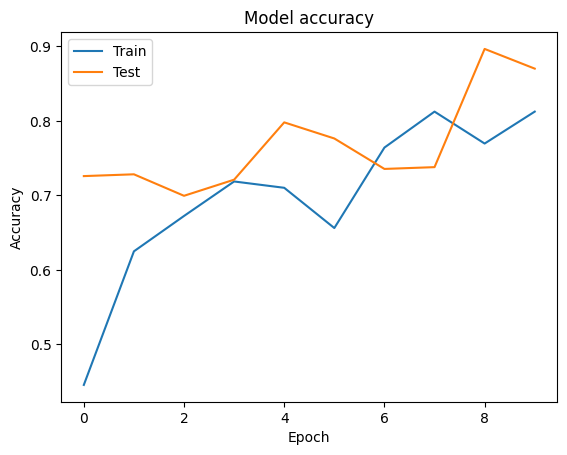

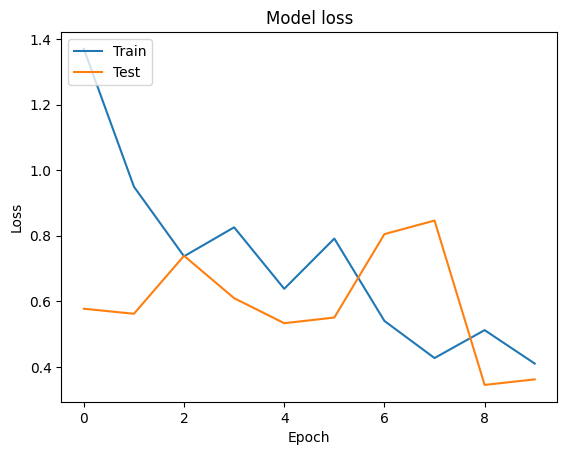

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Initialize the CNN model
model = models.Sequential()

# Add layers to the model
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))  # 6 classes in your case (engaged vs. not engaged)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # For integer class labels
              metrics=['accuracy'])

model.summary()  # Check the model architecture


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation

# Train the model
history = model.fit(
    train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='sparse'),
    epochs=10,
    validation_data=validation_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=32, class_mode='sparse')
)


Found 1699 images belonging to 6 classes.
Found 421 images belonging to 6 classes.
Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.2646 - loss: 1.8208 - val_accuracy: 0.4513 - val_loss: 1.1871
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.4540 - loss: 1.2609 - val_accuracy: 0.6580 - val_loss: 0.8234
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.5082 - loss: 1.1176 - val_accuracy: 0.8432 - val_loss: 0.5782
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.6022 - loss: 0.8845 - val_accuracy: 0.6698 - val_loss: 0.5538
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.6401 - loss: 0.7452 - val_accuracy: 0.6912 - val_loss: 0.5594
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6712 - loss: 0.6848 - val_accuracy: 0.6793 - val_loss: 0.5458
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.6733 - loss: 0.6909 - val_accuracy: 0.6912 - val_loss: 0.5122
Epoch 8/10
54/54 ━━━━━━━━━━━━━━

In [15]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(validation_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=32, class_mode='sparse'))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")



Found 421 images belonging to 6 classes.
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 436ms/step - accuracy: 0.6833 - loss: 0.5074
Test Loss: 0.47592514753341675
Test Accuracy: 0.7197149395942688


14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 763ms/step


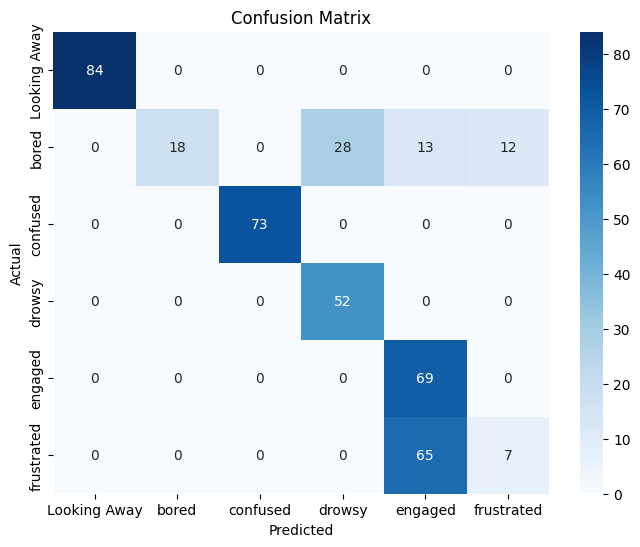

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Predict
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [22]:

# Classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

Looking Away       1.00      1.00      1.00        84
       bored       1.00      0.25      0.40        71
    confused       1.00      1.00      1.00        73
      drowsy       0.65      1.00      0.79        52
     engaged       0.47      1.00      0.64        69
  frustrated       0.37      0.10      0.15        72

    accuracy                           0.72       421
   macro avg       0.75      0.73      0.66       421
weighted avg       0.76      0.72      0.67       421



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


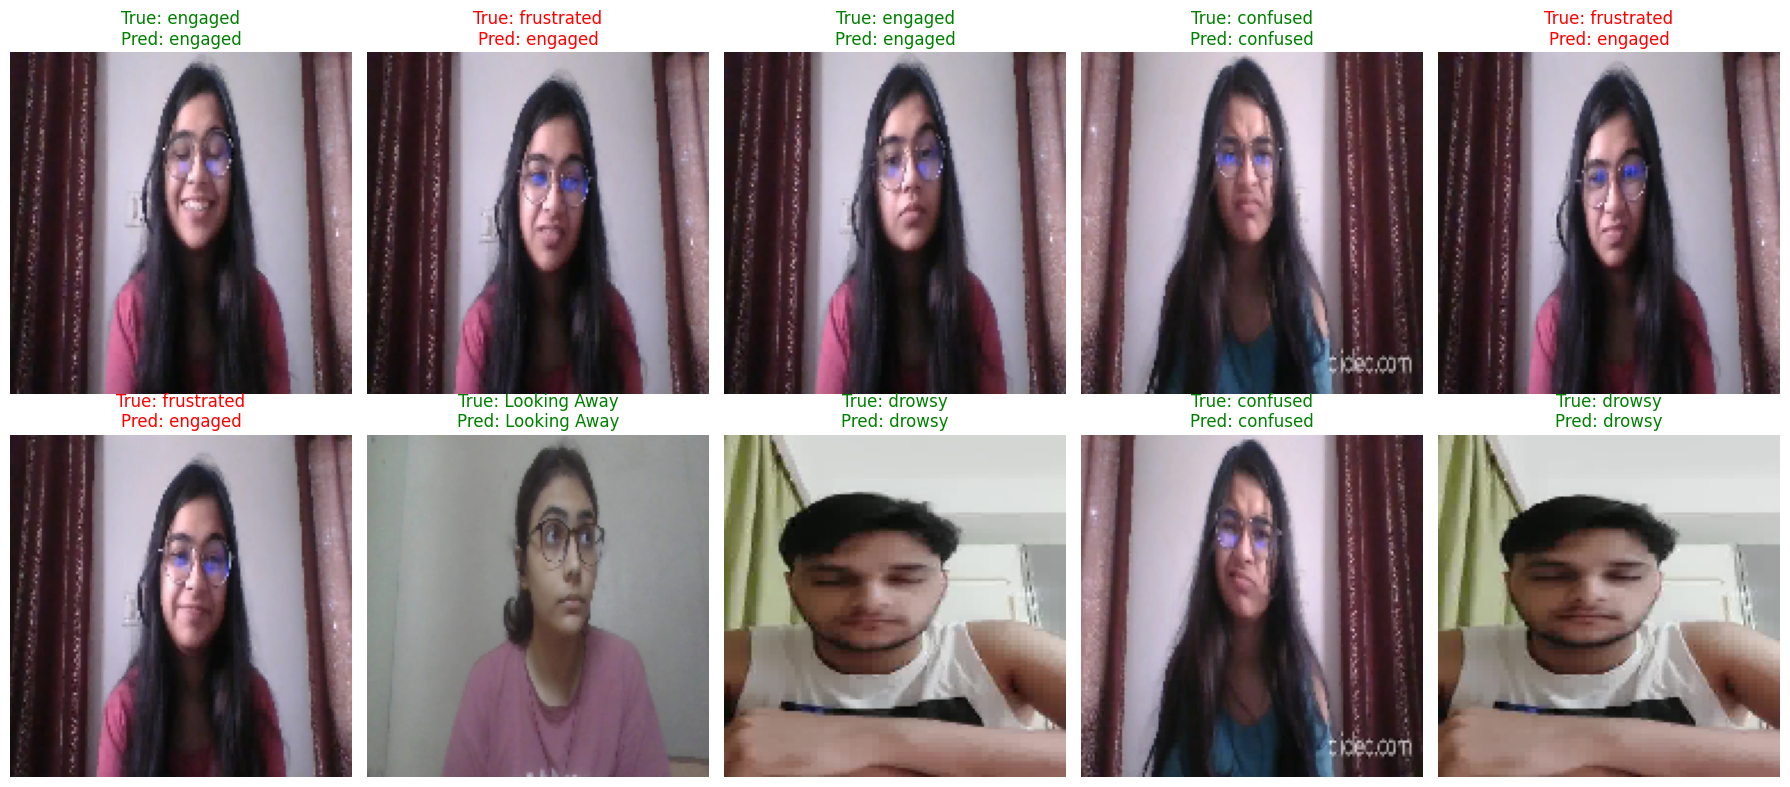

In [29]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
import os

# Define test directory and class labels
test_dir = '/content/test'
class_labels = list(test_generator.class_indices.keys())

# Gather all image paths with labels
all_image_paths = []
for label in class_labels:
    folder = os.path.join(test_dir, label)
    for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        all_image_paths.append((img_path, label))

# Select 10 random images
sample_images = random.sample(all_image_paths, 10)

# Visualize predictions
plt.figure(figsize=(18, 8))
for i, (img_path, true_label) in enumerate(sample_images):
    # Preprocess image
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0
    img_expanded = np.expand_dims(img_array, axis=0)

    # Predict
    pred = model.predict(img_expanded)
    pred_label = class_labels[np.argmax(pred)]

    # Plot
    plt.subplot(2, 5, i + 1)
    plt.imshow(img_array)
    plt.axis('off')
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


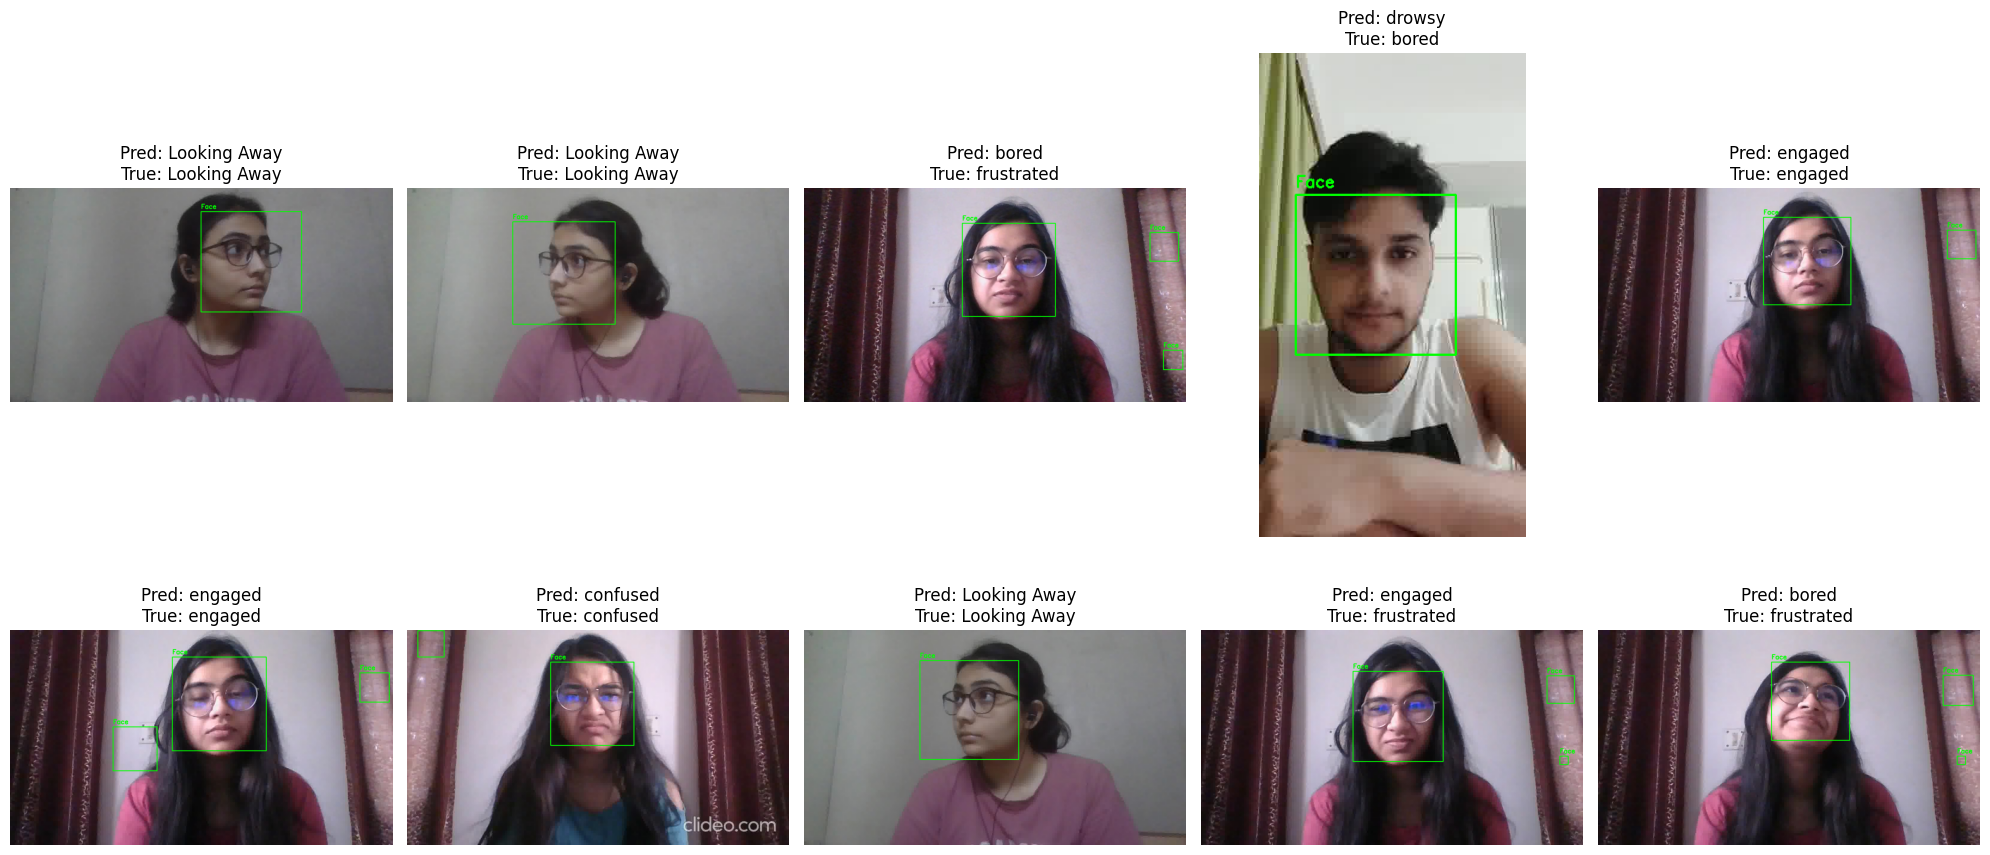

In [47]:
import cv2
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Load Haar cascade for face detection (pre-trained frontal face detector from OpenCV)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load class labels
class_labels = list(train_generator.class_indices.keys())

# Pick 10 random test images
num_images = 10
test_images = []
for _ in range(num_images):
    class_choice = random.choice(os.listdir(test_dir))
    img_name = random.choice(os.listdir(os.path.join(test_dir, class_choice)))
    img_path = os.path.join(test_dir, class_choice, img_name)
    test_images.append((img_path, class_choice))

# Plot predictions
plt.figure(figsize=(20, 10))

for idx, (img_path, true_class) in enumerate(test_images):
    # Read original image for visualization
    img_orig = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

    # Resize for model prediction
    img_resized = cv2.resize(img_orig, (150, 150))
    img_array = image.img_to_array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred = model.predict(img_array)
    predicted_class = class_labels[np.argmax(pred)]

    # Detect faces using Haar cascade
    faces = face_cascade.detectMultiScale(img_orig, scaleFactor=1.1, minNeighbors=5)

    # Draw rectangles and prediction label
    for (x, y, w, h) in faces:
        cv2.rectangle(img_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(img_rgb, "Face", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    # Show result
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img_rgb)
    plt.title(f"Pred: {predicted_class}\nTrue: {true_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Saving online-education-group-of-female-students-with-their-teacher-having-video-call-view-of-monitor-screen-2FNTBJT.jpg to online-education-group-of-female-students-with-their-teacher-having-video-call-view-of-monitor-screen-2FNTBJT.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


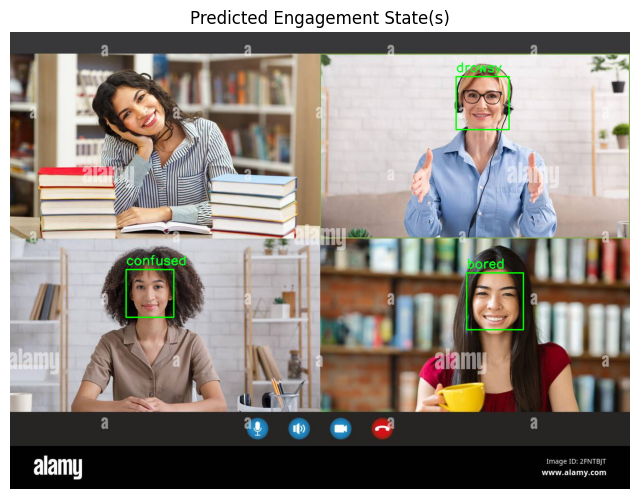

In [55]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from google.colab import files

# Upload image
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Load the image
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Detect faces
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

# Your trained model and class labels
# Make sure your `model` variable points to the trained model
class_labels = ['drowsy', 'bored', 'engaged', 'frustrated', 'Looking Away', 'confused']

# Process each face
for (x, y, w, h) in faces:
    face = img[y:y+h, x:x+w]
    face_resized = cv2.resize(face, (150, 150))
    face_array = img_to_array(face_resized) / 255.0
    face_array = np.expand_dims(face_array, axis=0)

    # Predict
    prediction = model.predict(face_array)
    predicted_class = class_labels[np.argmax(prediction)]

    # Draw rectangle & label
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(img, predicted_class, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

# Show result
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Predicted Engagement State(s)")
plt.show()


In [33]:
import bz2

# Define paths
bz2_path = '/content/mmod_human_face_detector.dat.bz2'
extracted_path = '/content/mmod_human_face_detector.dat'

# Extract the model
with bz2.BZ2File(bz2_path, 'rb') as fr, open(extracted_path, 'wb') as fw:
    fw.write(fr.read())

print("✅ Model extracted to:", extracted_path)


✅ Model extracted to: /content/mmod_human_face_detector.dat


# To save the trained Model for future use

In [ ]:
model.save('/content/engagement_model.h5')
